In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

Using TensorFlow backend.


importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [2]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


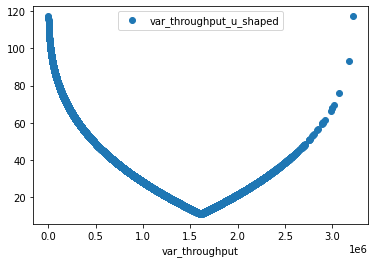

In [3]:
######################################
## Weighted Onehot Encoding options ##
######################################

##############
# Throughput #
##############
# TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# (For TP3 & TP4, k=1 results in V-shaped variance, and as k>1 increases, sides will curve into U-shaped variance)

############
# Worktime #
############
# WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

################
# PC agreement #
################
# PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)

#####################
# Input text length #
#####################
# TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

###################
# Special Options #
###################
# SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP2: weighted by average of WT1 and WT2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_UNI: weighted by 1 uniformly distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

# Select 1 option from each of the few variants above, e.g. TP2, WT1, PC3, TL1, SP3, and input into function
# set_OHE_pipeline_options. If not selecting TP3 or TP4, input k (option_k) will be ignored. After
# editing the options, run the entire notebook for results accordingly.

# Edit option choices here
throughput_option = 'TP4'
worktime_option = 'WT2'
pc_agreement_option = 'PC3'
textlength_option = 'TL2'
special_option = 'RAND_NORM'
k_option_for_tp = 3

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'lstm'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [6]:
# # Old train_test_split code
# train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

In [7]:
print(df.shape, train.shape, test.shape)

(11366, 862) (9092, 862) (2274, 862)


In [8]:
# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.23.2


In [9]:
new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].to_numpy()
deception_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_deception),
                                                 y_train_deception)
deception_class_weight_dict = dict(enumerate(deception_class_weights))

y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
rapport_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_rapport),
                                                 y_train_rapport)
rapport_class_weight_dict = dict(enumerate(rapport_class_weights))

y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
share_info_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_share_information),
                                                 y_train_share_information)
share_info_class_weight_dict = dict(enumerate(share_info_class_weights))

y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
reasoning_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_reasoning),
                                                 y_train_reasoning)
reasoning_class_weight_dict = dict(enumerate(reasoning_class_weights))

y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()
gamemove_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_gamemove),
                                                 y_train_gamemove)
gamemove_class_weight_dict = dict(enumerate(gamemove_class_weights))

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [10]:
print("Class weights")
print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                  rapport_class_weight_dict,
                                                                                                  share_info_class_weight_dict,
                                                                                                  reasoning_class_weight_dict,
                                                                                                  gamemove_class_weight_dict))

Class weights
Deception: {0: 10.192825112107624, 1: 0.525792273883877} 
Rapport: {0: 3.582348305752561, 1: 0.5811069922024799} 
Share Information: {0: 3.117969821673525, 1: 0.59549384333246} 
Reasoning: {0: 2.9596354166666665, 1: 0.6016410799364743} 
Gamemove: {0: 7.048062015503876, 1: 0.5381792352314431}


In [11]:
X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

In [12]:
le = LabelEncoder()

# def label_preprocessing(y_data, label_encoder):
#     out = label_encoder.fit_transform(y_data).reshape(-1,1)
#     return out

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [13]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

### Construct individual  models

In [14]:
# Rapport model
rapport_model = models_nn.create_nn_model()
rapport_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                              models_nn.recall_m, models_nn.precision_m])
rapport_model.fit(X_train,y_train_rapport,
                  batch_size=128,
                  epochs=50,
                  validation_data=(X_test, y_test_rapport), 
#                   callbacks=[models_nn.early_stop],
                  class_weight=rapport_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 4s 59ms/step - loss: 0.6932 - accuracy: 0.4210 - f1_m: 0.4341 - recall_m: 0.3975 - precision_m: 0.6900 - val_loss: 0.6267 - val_accuracy: 0.8712 - val_f1_m: 0.9305 - val_recall_m: 1.0000 - val_precision_m: 0.8704
Epoch 2/50
72/72 [==============================] - 5s 64ms/step - loss: 0.6881 - accuracy: 0.6493 - f1_m: 0.7418 - recall_m: 0.6962 - precision_m: 0.8826 - val_loss: 0.5789 - val_accuracy: 0.8267 - val_f1_m: 0.9041 - val_recall_m: 0.9434 - val_precision_m: 0.8686
Epoch 3/50
72/72 [==============================] - 3s 41ms/step - loss: 0.6692 - accuracy: 0.6121 - f1_m: 0.7271 - recall_m: 0.6200 - precision_m: 0.9035 - val_loss: 0.5818 - val_accuracy: 0.7388 - val_f1_m: 0.8453 - val_recall_m: 0.8255 - val_precision_m: 0.8668
Epoch 4/50
72/72 [==============================] - 3s 37ms/step - loss: 0.6480 - accuracy: 0.6249 - f1_m: 0.7350 - recall_m: 0.6235 - precision_m: 0.9166 - val_loss: 0.8807 - val_accuracy: 0.3276 - val_f1

Epoch 32/50
72/72 [==============================] - 2s 35ms/step - loss: 0.3318 - accuracy: 0.8017 - f1_m: 0.8580 - recall_m: 0.7694 - precision_m: 0.9736 - val_loss: 1.2483 - val_accuracy: 0.6961 - val_f1_m: 0.8112 - val_recall_m: 0.7581 - val_precision_m: 0.8736
Epoch 33/50
72/72 [==============================] - 2s 35ms/step - loss: 0.3258 - accuracy: 0.8013 - f1_m: 0.8685 - recall_m: 0.7789 - precision_m: 0.9871 - val_loss: 1.1071 - val_accuracy: 0.6557 - val_f1_m: 0.7791 - val_recall_m: 0.7037 - val_precision_m: 0.8743
Epoch 34/50
72/72 [==============================] - 2s 34ms/step - loss: 0.3164 - accuracy: 0.8117 - f1_m: 0.8788 - recall_m: 0.7939 - precision_m: 0.9882 - val_loss: 1.3254 - val_accuracy: 0.5721 - val_f1_m: 0.7078 - val_recall_m: 0.5997 - val_precision_m: 0.8655
Epoch 35/50
72/72 [==============================] - 3s 35ms/step - loss: 0.3064 - accuracy: 0.8103 - f1_m: 0.8749 - recall_m: 0.7895 - precision_m: 0.9870 - val_loss: 1.9247 - val_accuracy: 0.7221 - va

In [15]:
rapport_pred = rapport_model.predict(X_train)
rapport_pred_test = rapport_model.predict(X_test)

rapport_pred_test_round = rapport_pred_test.round()
precision_recall_fscore_support(y_test_rapport, rapport_pred_test_round, average='macro')

(0.564594356261023, 0.5015143866733973, 0.11742806178465376, None)

In [16]:
# Game move model
gamemove_model = models_nn.create_nn_model()
gamemove_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                               models_nn.recall_m, models_nn.precision_m])
gamemove_model.fit(X_train,
                   y_train_gamemove,
                   batch_size=128,
                   epochs=50,
                   validation_data=(X_test, y_test_gamemove), 
#                    callbacks=[models_nn.early_stop],
                   class_weight=gamemove_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 3s 43ms/step - loss: 0.6935 - accuracy: 0.6304 - f1_m: 0.6944 - recall_m: 0.6458 - precision_m: 0.8678 - val_loss: 0.6773 - val_accuracy: 0.9024 - val_f1_m: 0.9483 - val_recall_m: 0.9609 - val_precision_m: 0.9364
Epoch 2/50
72/72 [==============================] - 3s 36ms/step - loss: 0.6819 - accuracy: 0.6474 - f1_m: 0.7554 - recall_m: 0.6598 - precision_m: 0.9462 - val_loss: 0.5003 - val_accuracy: 0.8830 - val_f1_m: 0.9375 - val_recall_m: 0.9372 - val_precision_m: 0.9381
Epoch 3/50
72/72 [==============================] - 2s 35ms/step - loss: 0.6402 - accuracy: 0.6660 - f1_m: 0.7761 - recall_m: 0.6669 - precision_m: 0.9581 - val_loss: 0.5056 - val_accuracy: 0.7617 - val_f1_m: 0.8622 - val_recall_m: 0.7996 - val_precision_m: 0.9375
Epoch 4/50
72/72 [==============================] - 2s 34ms/step - loss: 0.6007 - accuracy: 0.6526 - f1_m: 0.7613 - recall_m: 0.6416 - precision_m: 0.9530 - val_loss: 0.5351 - val_accuracy: 0.7133 - val_f1

Epoch 32/50
72/72 [==============================] - 3s 42ms/step - loss: 0.2533 - accuracy: 0.8577 - f1_m: 0.9150 - recall_m: 0.8495 - precision_m: 0.9953 - val_loss: 0.9328 - val_accuracy: 0.7436 - val_f1_m: 0.8506 - val_recall_m: 0.7793 - val_precision_m: 0.9378
Epoch 33/50
72/72 [==============================] - 3s 40ms/step - loss: 0.2342 - accuracy: 0.8665 - f1_m: 0.9219 - recall_m: 0.8618 - precision_m: 0.9958 - val_loss: 0.9497 - val_accuracy: 0.7274 - val_f1_m: 0.8392 - val_recall_m: 0.7597 - val_precision_m: 0.9392
Epoch 34/50
72/72 [==============================] - 3s 37ms/step - loss: 0.2266 - accuracy: 0.8733 - f1_m: 0.9253 - recall_m: 0.8659 - precision_m: 0.9964 - val_loss: 1.0229 - val_accuracy: 0.7872 - val_f1_m: 0.8798 - val_recall_m: 0.8311 - val_precision_m: 0.9353
Epoch 35/50
72/72 [==============================] - 3s 38ms/step - loss: 0.2240 - accuracy: 0.8756 - f1_m: 0.9284 - recall_m: 0.8714 - precision_m: 0.9964 - val_loss: 1.2398 - val_accuracy: 0.7709 - va

In [17]:
gamemove_pred = gamemove_model.predict(X_train)
gamemove_pred_test = gamemove_model.predict(X_test)

gamemove_pred_test_round = gamemove_pred_test.round()
precision_recall_fscore_support(y_test_gamemove, gamemove_pred_test_round, average='macro')

(0.5010685075275043, 0.5039009856512433, 0.4510845201558674, None)

In [18]:
# Reasoning model
reasoning_model = models_nn.create_nn_model()
reasoning_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
reasoning_model.fit(X_train,
                    y_train_reasoning,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test_reasoning), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=reasoning_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 3s 43ms/step - loss: 0.6934 - accuracy: 0.3799 - f1_m: 0.3828 - recall_m: 0.3355 - precision_m: 0.6855 - val_loss: 0.6456 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 1.0000 - val_precision_m: 0.8212
Epoch 2/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6896 - accuracy: 0.6273 - f1_m: 0.7245 - recall_m: 0.6759 - precision_m: 0.8475 - val_loss: 0.7061 - val_accuracy: 0.4336 - val_f1_m: 0.5272 - val_recall_m: 0.3882 - val_precision_m: 0.8352
Epoch 3/50
72/72 [==============================] - 3s 36ms/step - loss: 0.6718 - accuracy: 0.6018 - f1_m: 0.7122 - recall_m: 0.6114 - precision_m: 0.8784 - val_loss: 0.6111 - val_accuracy: 0.6944 - val_f1_m: 0.8095 - val_recall_m: 0.7956 - val_precision_m: 0.8261
Epoch 4/50
72/72 [==============================] - 3s 36ms/step - loss: 0.6506 - accuracy: 0.6241 - f1_m: 0.7309 - recall_m: 0.6306 - precision_m: 0.8921 - val_loss: 0.6496 - val_accuracy: 0.6126 - val_f1

Epoch 32/50
72/72 [==============================] - 3s 36ms/step - loss: 0.3449 - accuracy: 0.7786 - f1_m: 0.8498 - recall_m: 0.7522 - precision_m: 0.9807 - val_loss: 1.4703 - val_accuracy: 0.6332 - val_f1_m: 0.7579 - val_recall_m: 0.7025 - val_precision_m: 0.8258
Epoch 33/50
72/72 [==============================] - 3s 35ms/step - loss: 0.3348 - accuracy: 0.7824 - f1_m: 0.8517 - recall_m: 0.7562 - precision_m: 0.9815 - val_loss: 2.0957 - val_accuracy: 0.5374 - val_f1_m: 0.6623 - val_recall_m: 0.5563 - val_precision_m: 0.8222
Epoch 34/50
72/72 [==============================] - 3s 35ms/step - loss: 0.3268 - accuracy: 0.7883 - f1_m: 0.8569 - recall_m: 0.7623 - precision_m: 0.9837 - val_loss: 1.9672 - val_accuracy: 0.5202 - val_f1_m: 0.6417 - val_recall_m: 0.5274 - val_precision_m: 0.8248
Epoch 35/50
72/72 [==============================] - 3s 35ms/step - loss: 0.3214 - accuracy: 0.7882 - f1_m: 0.8565 - recall_m: 0.7626 - precision_m: 0.9826 - val_loss: 1.6440 - val_accuracy: 0.5774 - va

In [19]:
reasoning_pred = reasoning_model.predict(X_train)
reasoning_pred_test = reasoning_model.predict(X_test)

reasoning_pred_test_round = reasoning_pred_test.round()
precision_recall_fscore_support(y_test_reasoning, reasoning_pred_test_round, average='macro')

(0.5248214910433665, 0.5349622495689912, 0.5196911912564537, None)

In [20]:
# Share Information model
shareinfo_model = models_nn.create_nn_model()
shareinfo_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
shareinfo_model.fit(X_train,
                    y_train_share_information,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test_share_information), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=share_info_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 3s 42ms/step - loss: 0.6932 - accuracy: 0.6985 - f1_m: 0.7259 - recall_m: 0.7759 - precision_m: 0.7325 - val_loss: 0.7248 - val_accuracy: 0.1557 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/50
72/72 [==============================] - 3s 35ms/step - loss: 0.6894 - accuracy: 0.5269 - f1_m: 0.6004 - recall_m: 0.5233 - precision_m: 0.7967 - val_loss: 0.7534 - val_accuracy: 0.2753 - val_f1_m: 0.2770 - val_recall_m: 0.1655 - val_precision_m: 0.8728
Epoch 3/50
72/72 [==============================] - 2s 34ms/step - loss: 0.6699 - accuracy: 0.5836 - f1_m: 0.6908 - recall_m: 0.5810 - precision_m: 0.8911 - val_loss: 0.6751 - val_accuracy: 0.5506 - val_f1_m: 0.6787 - val_recall_m: 0.5647 - val_precision_m: 0.8529
Epoch 4/50
72/72 [==============================] - 3s 35ms/step - loss: 0.6436 - accuracy: 0.6018 - f1_m: 0.7034 - recall_m: 0.5850 - precision_m: 0.9051 - val_loss: 0.5850 - val_accuracy: 0.6

Epoch 32/50
72/72 [==============================] - 3s 35ms/step - loss: 1.0962 - accuracy: 0.3789 - f1_m: 0.4088 - recall_m: 0.3212 - precision_m: 0.7828 - val_loss: 0.5562 - val_accuracy: 0.8443 - val_f1_m: 0.9147 - val_recall_m: 1.0000 - val_precision_m: 0.8436
Epoch 33/50
72/72 [==============================] - 3s 36ms/step - loss: 0.6997 - accuracy: 0.6362 - f1_m: 0.7570 - recall_m: 0.6827 - precision_m: 0.8578 - val_loss: 0.6118 - val_accuracy: 0.8281 - val_f1_m: 0.9046 - val_recall_m: 0.9753 - val_precision_m: 0.8445
Epoch 34/50
72/72 [==============================] - 3s 35ms/step - loss: 0.6646 - accuracy: 0.6199 - f1_m: 0.7224 - recall_m: 0.6151 - precision_m: 0.8999 - val_loss: 0.6521 - val_accuracy: 0.6447 - val_f1_m: 0.7674 - val_recall_m: 0.6993 - val_precision_m: 0.8529
Epoch 35/50
72/72 [==============================] - 3s 35ms/step - loss: 0.5807 - accuracy: 0.6552 - f1_m: 0.7526 - recall_m: 0.6395 - precision_m: 0.9334 - val_loss: 0.7010 - val_accuracy: 0.5915 - va

In [21]:
shareinfo_pred = shareinfo_model.predict(X_train)
shareinfo_pred_test = shareinfo_model.predict(X_test)

shareinfo_pred_test_round = shareinfo_pred_test.round()
precision_recall_fscore_support(y_test_share_information, shareinfo_pred_test_round, average='macro')

(0.5116028199579925, 0.5215218926553673, 0.47081800777834726, None)

In [22]:
# Deception model
deception_model = models_nn.create_nn_model()
deception_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
deception_model.fit(X_train,
                    y_train_deception,
                    epochs=50,
                    validation_data=(X_test, y_test_deception), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=deception_class_weight_dict)

Epoch 1/50
285/285 [==============================] - 7s 26ms/step - loss: 0.6964 - accuracy: 0.7945 - f1_m: 0.8697 - recall_m: 0.8306 - precision_m: 0.9516 - val_loss: 0.6307 - val_accuracy: 0.9507 - val_f1_m: 0.9747 - val_recall_m: 1.0000 - val_precision_m: 0.9514
Epoch 2/50
285/285 [==============================] - 7s 24ms/step - loss: 0.6868 - accuracy: 0.7476 - f1_m: 0.8308 - recall_m: 0.7647 - precision_m: 0.9617 - val_loss: 0.7131 - val_accuracy: 0.4028 - val_f1_m: 0.5509 - val_recall_m: 0.3971 - val_precision_m: 0.9607
Epoch 3/50
285/285 [==============================] - 7s 25ms/step - loss: 0.6662 - accuracy: 0.6093 - f1_m: 0.7236 - recall_m: 0.6104 - precision_m: 0.9638 - val_loss: 0.5164 - val_accuracy: 0.8105 - val_f1_m: 0.8941 - val_recall_m: 0.8421 - val_precision_m: 0.9579
Epoch 4/50
285/285 [==============================] - 7s 25ms/step - loss: 0.6468 - accuracy: 0.6252 - f1_m: 0.7411 - recall_m: 0.6244 - precision_m: 0.9676 - val_loss: 0.3992 - val_accuracy: 0.8769 

Epoch 32/50
285/285 [==============================] - 7s 24ms/step - loss: 0.3598 - accuracy: 0.8406 - f1_m: 0.9069 - recall_m: 0.8393 - precision_m: 0.9920 - val_loss: 0.6648 - val_accuracy: 0.7005 - val_f1_m: 0.8207 - val_recall_m: 0.7265 - val_precision_m: 0.9515
Epoch 33/50
285/285 [==============================] - 7s 24ms/step - loss: 0.3536 - accuracy: 0.8307 - f1_m: 0.9008 - recall_m: 0.8284 - precision_m: 0.9933 - val_loss: 0.8041 - val_accuracy: 0.6139 - val_f1_m: 0.7507 - val_recall_m: 0.6242 - val_precision_m: 0.9534
Epoch 34/50
285/285 [==============================] - 7s 24ms/step - loss: 0.3274 - accuracy: 0.8425 - f1_m: 0.9081 - recall_m: 0.8407 - precision_m: 0.9935 - val_loss: 0.6273 - val_accuracy: 0.7388 - val_f1_m: 0.8472 - val_recall_m: 0.7675 - val_precision_m: 0.9523
Epoch 35/50
285/285 [==============================] - 7s 24ms/step - loss: 0.3124 - accuracy: 0.8421 - f1_m: 0.9080 - recall_m: 0.8403 - precision_m: 0.9927 - val_loss: 0.6872 - val_accuracy: 0.7

In [23]:
deception_pred = deception_model.predict(X_train)
deception_pred_test = deception_model.predict(X_test)
deception_pred_test_round = deception_pred_test.round()
precision_recall_fscore_support(y_test_deception, deception_pred_test_round, average='macro')

(0.49798575115487215, 0.4938631558081142, 0.47785078423060623, None)

In [24]:
# deception_pred_test

In [25]:
# unique, counts = np.unique(deception_pred_test_round, return_counts=True)

In [26]:
# print(unique, counts)

In [27]:
# deception_model.history.history['val_f1_m']

### One hot encodings

In [28]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(gamemove_pred)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred[i][0]
    pred_obj_1['reasoning'] = reasoning_pred[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred[i][0]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [29]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(gamemove_pred_test)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred_test[i][0]
    pred_obj_1['reasoning'] = reasoning_pred_test[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred_test[i][0]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred_test[i][0]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

### Joint Model with one hot encoding 

In [30]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df_full,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.7323 - acc: 0.0922 - f1_m: 0.0848 - precision_m: 0.5897 - recall_m: 0.0472 - val_loss: 0.7774 - val_acc: 0.2498 - val_

143/143 [==============================] - 1s 4ms/step - loss: 0.6925 - acc: 0.6135 - f1_m: 0.7456 - precision_m: 0.9548 - recall_m: 0.6214 - val_loss: 0.6901 - val_acc: 0.5497 - val_f1_m: 0.6984 - val_precision_m: 0.9479 - val_recall_m: 0.5553
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6923 - acc: 0.6282 - f1_m: 0.7594 - precision_m: 0.9502 - recall_m: 0.6391 - val_loss: 0.6943 - val_acc: 0.5273 - val_f1_m: 0.6775 - val_precision_m: 0.9483 - val_recall_m: 0.5294
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.4557 - f1_m: 0.6070 - precision_m: 0.9545 - recall_m: 0.4497 - val_loss: 0.6921 - val_acc: 0.5347 - val_f1_m: 0.6845 - val_precision_m: 0.9497 - val_recall_m: 0.5378
Epoch 32/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6922 - acc: 0.6308 - f1_m: 0.7589 - precision_m: 0.9527 - recall_m: 0.6426 - val_loss: 0.6937 - val_acc: 0.5224 - val_f1_m: 0.6736 - val_precision_m: 0.9490 - val_r

In [31]:
joint_predict = joint_full_model.predict(pred_test_df_full)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.4990351263643189, 0.49486256112065546, 0.3819940841136931, None)

In [32]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1078 1196]


In [33]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = models_nn.create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6747 - acc: 0.7712 - f1_m: 0.8609 - precision_m: 0.8899 - recall_m: 0.8364 - val_loss: 0.6436 - val_acc: 0.7058 - val_f1

143/143 [==============================] - 0s 3ms/step - loss: 0.6106 - acc: 0.7242 - f1_m: 0.8228 - precision_m: 0.9186 - recall_m: 0.7474 - val_loss: 0.7384 - val_acc: 0.5743 - val_f1_m: 0.7106 - val_precision_m: 0.8699 - val_recall_m: 0.6037
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6101 - acc: 0.7251 - f1_m: 0.8227 - precision_m: 0.9187 - recall_m: 0.7476 - val_loss: 0.7450 - val_acc: 0.5660 - val_f1_m: 0.7025 - val_precision_m: 0.8699 - val_recall_m: 0.5921
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6096 - acc: 0.7271 - f1_m: 0.8228 - precision_m: 0.9160 - recall_m: 0.7494 - val_loss: 0.7544 - val_acc: 0.5532 - val_f1_m: 0.6895 - val_precision_m: 0.8696 - val_recall_m: 0.5739
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6098 - acc: 0.7113 - f1_m: 0.8117 - precision_m: 0.9234 - recall_m: 0.7267 - val_loss: 0.7487 - val_acc: 0.5580 - val_f1_m: 0.6947 - val_precision_m: 0.8684 - val_r

In [34]:
joint_predict = joint_full_model.predict(pred_test_df)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.4975940451823695, 0.494783204952165, 0.4442511189170852, None)

In [35]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 952 1322]


## Weighted against Throughput, WorkTime, PC Agreement & Text Length

In [36]:
# Train weighted encodings
pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)

In [37]:
# Test weighted encodings
pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)

## Throughput only

### Joint Model with one hot encoding 

In [38]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_throughput_test,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6935 - acc: 0.5263 - f1_m: 0.6605 - precision_m: 0.9446 - recall_m: 0.5281 - val_loss: 0.6960 

143/143 [==============================] - 1s 4ms/step - loss: 0.6916 - acc: 0.4688 - f1_m: 0.6185 - precision_m: 0.9566 - recall_m: 0.4619 - val_loss: 0.6883 - val_acc: 0.3522 - val_f1_m: 0.4902 - val_precision_m: 0.9557 - val_recall_m: 0.3336
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6917 - acc: 0.2881 - f1_m: 0.4079 - precision_m: 0.9610 - recall_m: 0.2624 - val_loss: 0.6935 - val_acc: 0.2920 - val_f1_m: 0.4130 - val_precision_m: 0.9553 - val_recall_m: 0.2669
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6916 - acc: 0.3400 - f1_m: 0.4763 - precision_m: 0.9578 - recall_m: 0.3214 - val_loss: 0.6881 - val_acc: 0.3496 - val_f1_m: 0.4865 - val_precision_m: 0.9593 - val_recall_m: 0.3295
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6916 - acc: 0.3652 - f1_m: 0.5053 - precision_m: 0.9595 - recall_m: 0.3490 - val_loss: 0.6830 - val_acc: 0.4011 - val_f1_m: 0.5475 - val_precision_m: 0.9551 - val_r

In [39]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.5022602431777309, 0.5114601229020748, 0.32348865574412167, None)

In [40]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1392  882]


In [41]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [42]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_throughput_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6868 - acc: 0.2710 - f1_m: 0.2308 - precision_m: 0.4213 - recall_m: 0.1603 - val_loss: 0.7213 - 

143/143 [==============================] - 0s 3ms/step - loss: 0.6021 - acc: 0.6888 - f1_m: 0.7924 - precision_m: 0.9298 - recall_m: 0.6936 - val_loss: 0.6922 - val_acc: 0.5915 - val_f1_m: 0.7155 - val_precision_m: 0.9011 - val_recall_m: 0.5964
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6018 - acc: 0.6873 - f1_m: 0.7908 - precision_m: 0.9302 - recall_m: 0.6905 - val_loss: 0.6909 - val_acc: 0.5928 - val_f1_m: 0.7167 - val_precision_m: 0.9013 - val_recall_m: 0.5979
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6015 - acc: 0.6983 - f1_m: 0.7975 - precision_m: 0.9229 - recall_m: 0.7076 - val_loss: 0.7090 - val_acc: 0.5787 - val_f1_m: 0.7026 - val_precision_m: 0.9040 - val_recall_m: 0.5777
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6017 - acc: 0.6799 - f1_m: 0.7848 - precision_m: 0.9310 - recall_m: 0.6810 - val_loss: 0.6987 - val_acc: 0.5836 - val_f1_m: 0.7079 - val_precision_m: 0.9017 - val_r

In [43]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5361724723874257, 0.5792184455397953, 0.48592013120092054, None)

In [44]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 990 1284]


## WorkTime only

### Joint Model with one hot encoding 

In [45]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_worktime_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.8476 - f1_m: 0.8600 - precision_m: 0.8787 - recall_m: 0.8820 - val_loss: 0.6932 - 

143/143 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.7370 - f1_m: 0.7511 - precision_m: 0.8721 - recall_m: 0.7667 - val_loss: 0.6906 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.8947 - f1_m: 0.9173 - precision_m: 0.9468 - recall_m: 0.9392 - val_loss: 0.6917 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6929 - acc: 0.5112 - f1_m: 0.5179 - precision_m: 0.8898 - recall_m: 0.5185 - val_loss: 0.6890 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 32/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6929 - acc: 0.2489 - f1_m: 0.2367 - precision_m: 0.7870 - recall_m: 0.2274 - val_loss: 0.6929 - val_acc: 0.0730 - val_f1_m: 0.0507 - val_precision_m: 0.8056 - val_r

In [46]:
joint_predict = joint_full_model.predict(pred_df_full_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.49961607949412823, 0.49978938152504293, 0.07251413017484035, None)

In [47]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [2214   60]


In [48]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_worktime_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.8380 - f1_m: 0.8984 - precision_m: 0.8362 - recall_m: 0.9720 - val_loss: 0.6924 - va

143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.7509 - f1_m: 0.7883 - precision_m: 0.7335 - recall_m: 0.8531 - val_loss: 0.6920 - val_acc: 0.8712 - val_f1_m: 0.9299 - val_precision_m: 0.8698 - val_recall_m: 1.0000
Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.7553 - f1_m: 0.7945 - precision_m: 0.7392 - recall_m: 0.8601 - val_loss: 0.6914 - val_acc: 0.8712 - val_f1_m: 0.9299 - val_precision_m: 0.8698 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.8386 - f1_m: 0.8976 - precision_m: 0.8349 - recall_m: 0.9720 - val_loss: 0.6913 - val_acc: 0.8712 - val_f1_m: 0.9299 - val_precision_m: 0.8698 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.5069 - f1_m: 0.4779 - precision_m: 0.4445 - recall_m: 0.5175 - val_loss: 0.6919 - val_acc: 0.8712 - val_f1_m: 0.9299 - val_precision_m: 0.8698 - val_r

In [49]:
joint_predict = joint_full_model.predict(pred_df_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4355760773966579, 0.5, 0.4655699177438308, None)

In [50]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[1.] [2274]


## PC Agreement only

### Joint Model with one hot encoding 

In [51]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_agreement_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by PC Agreement
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.3205 - f1_m: 0.3542 - precision_m: 0.4156 - recall_m: 0.3099 - val_loss: 0.698

Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.0491 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6960 - val_acc: 0.0493 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.8428 - f1_m: 0.9108 - precision_m: 0.9445 - recall_m: 0.8813 - val_loss: 0.6945 - val_acc: 0.8153 - val_f1_m: 0.8968 - val_precision_m: 0.9520 - val_recall_m: 0.8491
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.8114 - f1_m: 0.8650 - precision_m: 0.8843 - recall_m: 0.8475 - val_loss: 0.6938 - val_acc: 0.8193 - val_f1_m: 0.8991 - val_precision_m: 0.9522 - val_recall_m: 0.8532
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.8550 - f1_m: 0.9191 - precision_m: 0.9518 - recall_m: 0.8906 - val_loss: 0.6935 - val_acc: 0.8351 - val_f1_m: 0.90

In [52]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.47493236247035636, 0.4650889939062734, 0.467134563754074, None)

In [53]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 441 1833]


In [54]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [55]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_agreement_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6431 - acc: 0.8490 - f1_m: 0.9130 - precision_m: 0.8908 - recall_m: 0.9397 - val_loss: 0.5706 

143/143 [==============================] - 0s 3ms/step - loss: 0.5701 - acc: 0.6482 - f1_m: 0.7524 - precision_m: 0.9471 - recall_m: 0.6271 - val_loss: 0.6404 - val_acc: 0.5558 - val_f1_m: 0.6681 - val_precision_m: 0.9427 - val_recall_m: 0.5197
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.5697 - acc: 0.6497 - f1_m: 0.7525 - precision_m: 0.9455 - recall_m: 0.6280 - val_loss: 0.6512 - val_acc: 0.5488 - val_f1_m: 0.6601 - val_precision_m: 0.9456 - val_recall_m: 0.5092
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.5694 - acc: 0.6359 - f1_m: 0.7422 - precision_m: 0.9484 - recall_m: 0.6127 - val_loss: 0.6394 - val_acc: 0.5585 - val_f1_m: 0.6714 - val_precision_m: 0.9424 - val_recall_m: 0.5237
Epoch 32/32
143/143 [==============================] - 1s 4ms/step - loss: 0.5693 - acc: 0.6577 - f1_m: 0.7617 - precision_m: 0.9459 - recall_m: 0.6418 - val_loss: 0.6543 - val_acc: 0.5453 - val_f1_m: 0.6565 - val_precision_m: 0.9459 - val_r

In [56]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5416896686284707, 0.5852199995520586, 0.5167525122456194, None)

In [57]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 811 1463]


## Text Length only

### Joint Model with one hot encoding 

In [58]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_textlength_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by text length
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6937 - acc: 0.4751 - f1_m: 0.6200 - precision_m: 0.9418 - recall_m: 0.4745 - val_loss: 0.7021

143/143 [==============================] - 1s 4ms/step - loss: 0.6931 - acc: 0.6170 - f1_m: 0.7505 - precision_m: 0.9549 - recall_m: 0.6300 - val_loss: 0.6897 - val_acc: 0.6988 - val_f1_m: 0.8177 - val_precision_m: 0.9556 - val_recall_m: 0.7169
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6930 - acc: 0.7467 - f1_m: 0.8530 - precision_m: 0.9514 - recall_m: 0.7750 - val_loss: 0.6878 - val_acc: 0.7304 - val_f1_m: 0.8399 - val_precision_m: 0.9552 - val_recall_m: 0.7515
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6931 - acc: 0.7747 - f1_m: 0.8707 - precision_m: 0.9526 - recall_m: 0.8053 - val_loss: 0.6900 - val_acc: 0.6917 - val_f1_m: 0.8124 - val_precision_m: 0.9567 - val_recall_m: 0.7082
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5863 - f1_m: 0.7271 - precision_m: 0.9539 - recall_m: 0.5959 - val_loss: 0.6936 - val_acc: 0.6284 - val_f1_m: 0.7634 - val_precision_m: 0.9576 - val_r

In [59]:
joint_predict = joint_full_model.predict(pred_df_full_textlength_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.5101864946635638, 0.5505979912779173, 0.43740080007003473, None)

In [60]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 837 1437]


In [61]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_textlength_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by text length
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6827 - acc: 0.7475 - f1_m: 0.8352 - precision_m: 0.8974 - recall_m: 0.8013 - val_loss: 0.6514 -

143/143 [==============================] - 0s 3ms/step - loss: 0.6253 - acc: 0.6080 - f1_m: 0.7204 - precision_m: 0.9268 - recall_m: 0.5930 - val_loss: 0.6466 - val_acc: 0.5726 - val_f1_m: 0.6997 - val_precision_m: 0.9004 - val_recall_m: 0.5749
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6253 - acc: 0.6160 - f1_m: 0.7281 - precision_m: 0.9250 - recall_m: 0.6043 - val_loss: 0.6670 - val_acc: 0.5550 - val_f1_m: 0.6814 - val_precision_m: 0.9038 - val_recall_m: 0.5500
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6251 - acc: 0.6216 - f1_m: 0.7349 - precision_m: 0.9242 - recall_m: 0.6137 - val_loss: 0.6899 - val_acc: 0.5321 - val_f1_m: 0.6566 - val_precision_m: 0.9052 - val_recall_m: 0.5179
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6249 - acc: 0.6119 - f1_m: 0.7253 - precision_m: 0.9253 - recall_m: 0.5992 - val_loss: 0.6831 - val_acc: 0.5400 - val_f1_m: 0.6646 - val_precision_m: 0.9051 - val_r

In [62]:
joint_predict = joint_full_model.predict(pred_df_textlength_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5341503893782714, 0.5760423683698204, 0.4628304402497543, None)

In [63]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1119 1155]


## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

### Joint Model with one hot encoding 

In [ ]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by special option
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6930 - acc: 0.4085 - f1_m: 0.5397 - precision_m: 0.9519 - recall_m: 0.4008 - val_loss: 0.6

In [ ]:
joint_predict = joint_full_model.predict(pred_df_full_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

In [ ]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

In [ ]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [ ]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

In [ ]:
joint_predict = joint_full_model.predict(pred_df_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

In [ ]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)